In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from src.comb import incremental_levels
from src.dataset import process_dataset

sns.set_context('notebook')
sns.set_style('whitegrid')

NUM_LAYERS = 0 # 3
NUM_UNITS = [8, 16, 32]
EPOCHS = 1000

In [2]:
df = pd.read_csv('../res/dataset.csv')
df

,hosp_0,diag_0,dead_0,hosp_1,diag_1,dead_1,hosp_2,diag_2,dead_2,hosp_3,...,diag_39,dead_39,hosp_40,diag_40,dead_40,hosp_41,diag_41,dead_41,init_zone,actuated_zone
0,98.0,7137.0,420.0,106.0,7255.0,421.0,107.0,7344.0,424.0,116.0,...,10723.0,550.0,143.0,10759.0,552.0,135.0,10778.0,553.0,Y,R
1,224.0,9389.0,463.0,219.0,9524.0,470.0,223.0,9652.0,474.0,227.0,...,11416.0,576.0,78.0,11444.0,577.0,83.0,11525.0,578.0,R,W
2,119.0,10800.0,556.0,109.0,10817.0,558.0,100.0,10840.0,559.0,91.0,...,13564.0,619.0,199.0,13710.0,621.0,196.0,13822.0,627.0,W,Y
3,94.0,11575.0,578.0,96.0,11674.0,580.0,106.0,11774.0,580.0,111.0,...,15288.0,700.0,144.0,15309.0,701.0,138.0,15324.0,706.0,Y,R
4,193.0,13887.0,633.0,198.0,14057.0,635.0,199.0,14202.0,640.0,206.0,...,15779.0,732.0,35.0,15807.0,734.0,36.0,15840.0,735.0,R,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,128.0,10591.0,541.0,121.0,10614.0,543.0,104.0,10628.0,547.0,89.0,...,10847.0,566.0,9.0,10854.0,566.0,10.0,10868.0,566.0,R,O
1396,15.0,10763.0,565.0,14.0,10764.0,565.0,13.0,10765.0,565.0,11.0,...,11016.0,571.0,18.0,11017.0,571.0,13.0,11017.0,572.0,O,R
1397,10.0,10875.0,566.0,13.0,10891.0,566.0,16.0,10903.0,566.0,16.0,...,11220.0,575.0,15.0,11231.0,575.0,14.0,11244.0,576.0,R,W
1398,11.0,11018.0,573.0,6.0,11020.0,574.0,5.0,11022.0,574.0,4.0,...,11729.0,586.0,46.0,11750.0,588.0,36.0,11759.0,593.0,W,O


In [3]:
(xtr, ytr), (xvl, yvl), _ = process_dataset(df, val_split=0.2)
print(f'x train: {xtr.shape}, x val: {xvl.shape}')
print(f'y train: {ytr.shape}, y val: {yvl.shape}')

x train: (1400, 53), x val: (280, 53)
y train: (1400, 2), y val: (280, 2)


In [4]:
scores = {}
configurations = incremental_levels(num_levels=NUM_LAYERS, parameters=NUM_UNITS)

for idx, config in enumerate(configurations):
    print(f'Model {idx + 1:0{len(str(len(configurations)))}}/{len(configurations)}', end='')
    start_time = time.time()
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    model = Sequential([Dense(hu, activation='relu') for hu in config] + [Dense(2)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(xtr, ytr, validation_split=0.2, epochs=EPOCHS, callbacks=[early_stopping], verbose=False)
    ptr, pvl = model.predict(xtr), model.predict(xvl)
    config = config + (0,) * NUM_LAYERS
    config = config[:NUM_LAYERS]
    scores[(0,) if config == () else config] = {
        'train_mse': mean_squared_error(ytr, ptr),
        'train_r2': r2_score(ytr, ptr),
        'val_mse': mean_squared_error(yvl, pvl),
        'val_r2': r2_score(yvl, pvl)
    }
    print(f' -- elapsed time: {time.time() - start_time:.4}s')

Model 1/1 -- elapsed time: 77.78s


In [5]:
results = pd.DataFrame.from_dict(scores, orient='index').sort_values('val_r2', ascending=False)
results

,train_mse,train_r2,val_mse,val_r2
0,0.000706,0.958139,0.000749,0.959484


In [6]:
best_config = results.index[0]
(x, y), (x_scaler, y_scaler) = process_dataset(df, val_split=None)

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model = Sequential([Dense(hu, activation='relu') for hu in best_config if hu != 0] + [Dense(2)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(x, y, validation_split=0.2, epochs=EPOCHS, callbacks=[early_stopping], verbose=True)

Epoch 1/1000
35/35 [==============================] - 0s 6ms/step - loss: 1.2780 - val_loss: 0.4020
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.4298 - val_loss: 0.2209
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.2224 - val_loss: 0.1301
Epoch 4/1000
35/35 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0782
Epoch 5/1000
35/35 [==============================] - 0s 3ms/step - loss: 0.0796 - val_loss: 0.0492
Epoch 6/1000
35/35 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0314
Epoch 7/1000
35/35 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0215
Epoch 8/1000
35/35 [

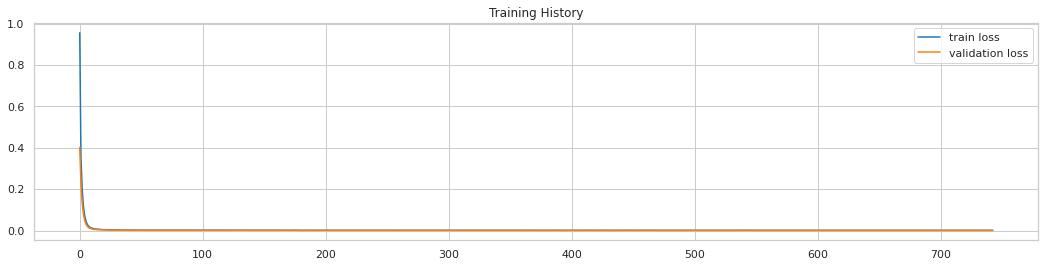

In [7]:
plt.figure(figsize=(18, 4))
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss').set(title='Training History')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')
plt.show()

MSE: 1598.8313, R2: 0.9568929844300333


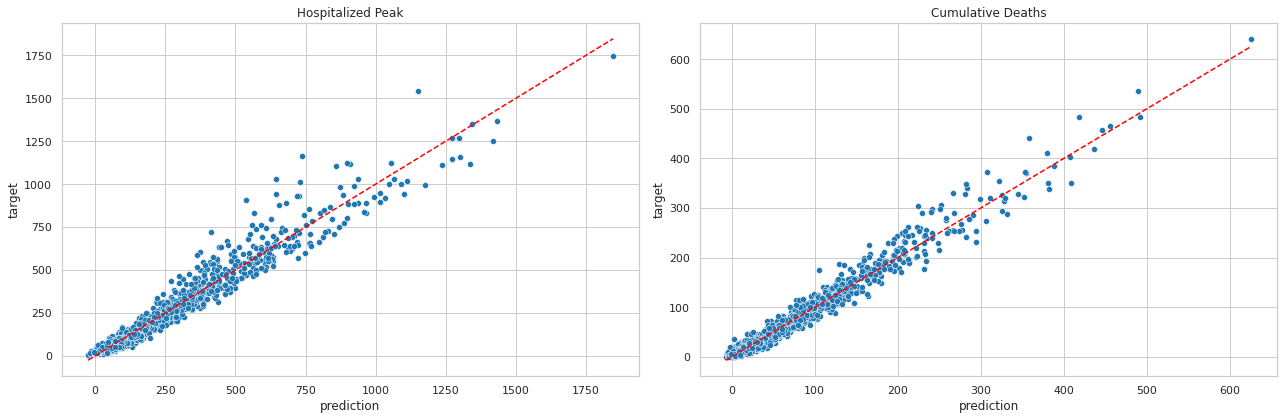

In [8]:
p = model.predict(x)
y, p = y_scaler.inverse_transform(y), y_scaler.inverse_transform(p)
print(f'MSE: {mean_squared_error(y, p):.4f}, R2: {r2_score(y, p)}:.4f')

_, axes = plt.subplots(1, 2, figsize=(18, 6), tight_layout=True)
for idx, title in enumerate(['Hospitalized Peak', 'Cumulative Deaths']):
    pp, yy = p[:, idx], y[:, idx]
    sns.scatterplot(x=pp, y=yy, ax=axes[idx]).set(xlabel='prediction', ylabel='target', title=title)
    axes[idx].plot([pp.min(), pp.max()], [pp.min(), pp.max()], 'r--')

## Test Set

In [16]:
from data import get_regional_data

region = 'Emilia-Romagna'
tot_pop = 4.46e6
region_zones = {
    '2020-05-18': 'W',
    '2020-11-08': 'Y',
    '2020-11-15': 'O',
    '2020-12-10': 'Y',
    '2020-12-21': 'O',
    '2021-02-01': 'Y',
    '2021-02-21': 'O',
    '2021-03-01': 'R',
    '2021-04-12': 'O',
    '2021-04-26': 'Y'
}
pop_size = 400e3
df = get_regional_data(scaling_factor=tot_pop/pop_size, region=region)
df

,date,n_severe,n_critical,cum_diagnoses,cum_deaths,new_tests
0,2020-02-24,0.896861,0.179372,1.614350,0.000000,13.273543
1,2020-02-25,1.345291,0.179372,2.331839,0.000000,21.793722
2,2020-02-26,1.793722,0.269058,4.215247,0.089686,16.681614
3,2020-02-27,3.228700,0.538117,8.699552,0.089686,40.896861
4,2020-02-28,5.022422,0.538117,13.004484,0.179372,21.883408
...,...,...,...,...,...,...
426,2021-04-25,165.201794,23.766816,32715.874439,1146.547085,1482.690583
427,2021-04-26,166.905830,24.035874,32799.551570,1148.071749,1134.080717
428,2021-04-27,164.394619,22.062780,32863.856502,1149.775785,2758.385650
429,2021-04-28,160.538117,22.421525,32921.165919,1151.838565,2655.515695


In [17]:
from interventions import get_delta

time_interval = 21
zones = [
    (range(get_delta(d) - time_interval, get_delta(d) + time_interval), z)
    for d, z in region_zones.items()
]

samples = {
    days: (init_zone, actuated_zone)
    for (_, init_zone), (days, actuated_zone) in zip(zones[:-3], zones[1:-2])
}

samples

{range(237, 279): ('W', 'Y'),
 range(244, 286): ('Y', 'O'),
 range(269, 311): ('O', 'Y'),
 range(280, 322): ('Y', 'O'),
 range(322, 364): ('O', 'Y'),
 range(342, 384): ('Y', 'O'),
 range(350, 392): ('O', 'R')}

In [18]:
import numpy as np
import pandas as pd

real_data = []
for period, zones in samples.items():
    temp = df.iloc[period]
    row = np.concatenate((
        temp['n_severe'].values + temp['n_critical'].values,
        temp['new_diagnoses'].values,
        temp['new_deaths'].values
    )).reshape(3, -1).transpose().flatten()
    real_data.append(list(row) + list(zones))
columns = [f'{c}_{d}' for d in range(0, 2 * time_interval) for c in ['hosp', 'diag', 'dead']] + ['init_zone', 'actuated_zone']
real_df = pd.DataFrame(real_data, columns=columns)
real_df

,hosp_0,diag_0,dead_0,hosp_1,diag_1,dead_1,hosp_2,diag_2,dead_2,hosp_3,...,diag_39,dead_39,hosp_40,diag_40,dead_40,hosp_41,diag_41,dead_41,init_zone,actuated_zone
0,45.381166,3664.484305,404.932735,49.417040,3713.901345,405.201794,54.618834,3759.372197,405.650224,61.165919,...,10300.896861,497.578475,262.152466,10494.977578,503.497758,261.704036,10689.147982,509.775785,W,Y
1,75.784753,4191.390135,409.058296,81.524664,4293.901345,409.327354,93.004484,4420.179372,410.672646,100.269058,...,11468.161435,534.439462,265.919283,11660.000000,540.089686,264.573991,11836.143498,544.753363,Y,O
2,245.112108,8772.556054,467.982063,249.147982,8999.461883,472.197309,254.260090,9243.408072,476.412556,261.434978,...,14984.484305,674.798206,252.825112,15064.484305,682.869955,257.488789,15192.466368,689.058296,O,Y
3,269.417040,11037.937220,515.964126,266.905830,11169.596413,520.627803,263.587444,11310.313901,526.816143,261.255605,...,16763.497758,736.322870,261.793722,16923.856502,742.511211,263.856502,17120.358744,747.713004,Y,O
4,267.174888,17294.349776,753.632287,266.098655,17434.529148,758.206278,260.807175,17540.179372,764.125561,254.977578,...,21745.470852,922.062780,186.098655,21898.654709,924.125561,190.403587,22064.573991,927.802691,O,Y
5,207.892377,19609.955157,849.865471,214.170404,19704.215247,852.914798,212.914798,19782.511211,859.282511,207.713004,...,26005.112108,982.869955,318.116592,26313.901345,986.008969,323.587444,26576.143498,988.789238,Y,O
6,195.964126,20466.188341,885.112108,193.094170,20552.197309,889.147982,190.134529,20634.798206,892.466368,186.636771,...,27980.986547,1017.309417,351.569507,28208.609865,1021.524664,355.336323,28427.533632,1024.573991,O,R


In [19]:
from dataset import process_dataset

(x_test, y_test), (x_scaler, y_scaler) = process_dataset(real_df, val_split=None)
print(f'x test: {x_test.shape}, y test: {y_test.shape}')

x test: (7, 53), y test: (7, 2)


MSE: 2760.7384, R2: -1.2366368539008175:.4f


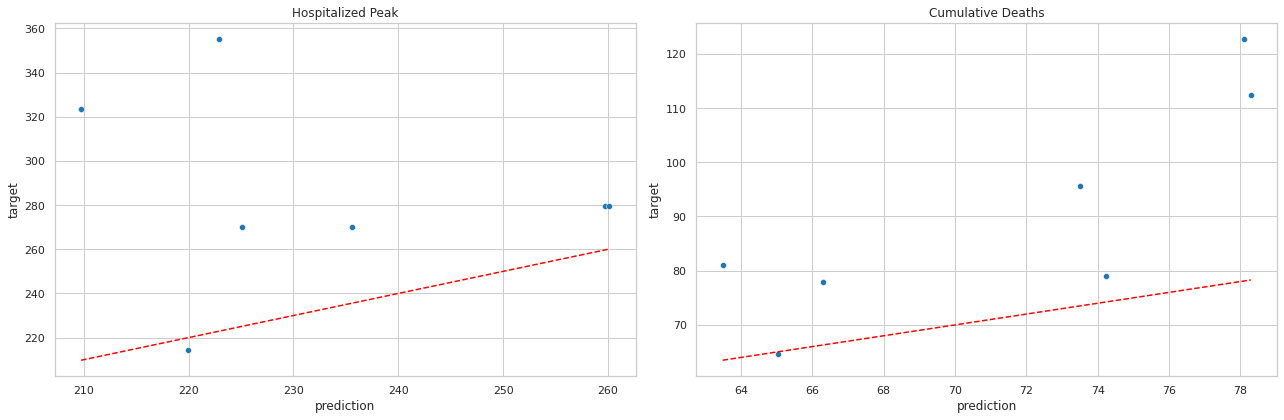

In [20]:
p_test = model.predict(x_test)
y_test, p_test = y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(p_test)
print(f'MSE: {mean_squared_error(y_test, p_test):.4f}, R2: {r2_score(y_test, p_test)}:.4f')

_, axes = plt.subplots(1, 2, figsize=(18, 6), tight_layout=True)
for idx, title in enumerate(['Hospitalized Peak', 'Cumulative Deaths']):
    pp, yy = p_test[:, idx], y_test[:, idx]
    sns.scatterplot(x=pp, y=yy, ax=axes[idx]).set(xlabel='prediction', ylabel='target', title=title)
    axes[idx].plot([pp.min(), pp.max()], [pp.min(), pp.max()], 'r--')